In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
import itertools
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from fuzzywuzzy import fuzz
import ipywidgets as widgets
from IPython.display import display
import squarify

# read csv for games
game_data = pd.read_csv(r"C:\Users\firen\OneDrive\Documents\School-LAPTOP-JU6N3L8Q\Capstone\Steam Games Dataset\steam.csv")

pd.options.display.show_dimensions = False

# prints full frame
def print_full(x):
    pd.set_option('display.max_rows', len(x))
    print(x)
    pd.reset_option('display.max_rows')


# test for loaded csv
# print(game_data.shape)
# print(game_data.head())

# check for null values
# print(game_data.columns[game_data.isna().any()].tolist())
# how many null values
# game_data.isnull().sum()


# convert full date to just the year
def convert_date_to_year(date):
    year = date[:4]
    if year.isnumeric():
        return int(year)
    else:
        return np.nan


game_data['year'] = game_data['release_date'].apply(convert_date_to_year)


# calc pos rating percentage using pos and neg ratings to create new column 'rating_score'
def calc_pos_rating_percentage(row):
    pos_ratings = row['positive_ratings']
    neg_ratings = row['negative_ratings']
    total_count = pos_ratings + neg_ratings
    average = pos_ratings / total_count
    return round(average, 2)


# calc rating sum using pos and neg ratings to create new column 'rating_sum'
def calc_rating_sum(row):
    pos_ratings = row['positive_ratings']
    neg_ratings = row['negative_ratings']
    rating_sum = pos_ratings + neg_ratings
    return rating_sum


game_data['pos_rating_percentage'] = game_data.apply(calc_pos_rating_percentage, axis=1)
game_data['rating_sum'] = game_data.apply(calc_rating_sum, axis=1)

# calc the mean of the pos rating percentage
C = game_data['pos_rating_percentage'].mean()
# TEST
# print(C)

# calc min number of ratings required to be considered for recommendation; only the top 10% considered
m = game_data['rating_sum'].quantile(0.85)

# remove games below this percentile so that jupyter notebooks can handle the data size
game_data.drop(game_data[game_data.rating_sum < m].index, inplace=True)


# reset index to fix errors
game_data.reset_index(inplace  = True)
# TEST
# print(m)


# calc and create a weighted rating for each game using the above variables
def calc_weighted_rating(x, m=m, C=C):
    v = x['rating_sum']
    R = x['pos_rating_percentage']
    # below formula based on IMDB weighted rating formula to be cited
    return round((v / (v + m) * R) + (m / (m + v) * C), 2) * 100


# create new column 'weighted_rating' from the above formula
game_data['weighted_rating'] = game_data.apply(calc_weighted_rating, axis=1)

# TEST print head to ensure above worked
# display(game_data[['name', 'year', 'rating_sum', 'pos_rating_percentage', 'weighted_rating']].head(20))

,Genre,Occurrences
0,Indie,2374
1,Action,2039
2,Adventure,1492
3,RPG,934
4,Strategy,904
5,Simulation,817
6,Casual,797
7,Free to Play,541
8,Early Access,300
9,Massively Multiplayer,270


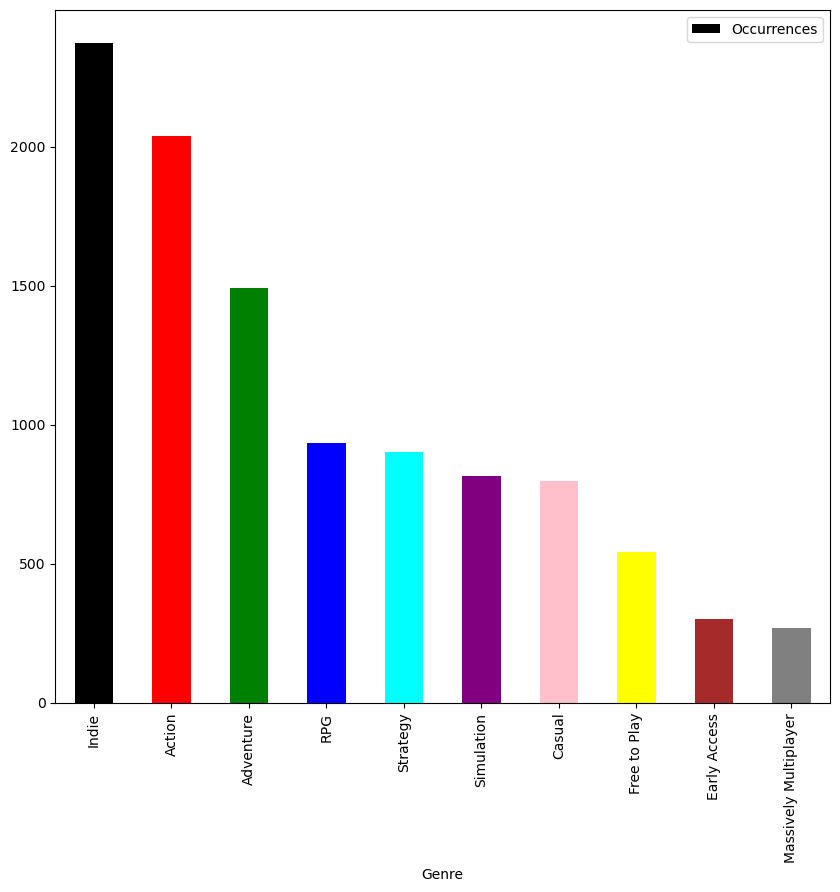

In [4]:
# find 10 most common unique genres listed in the genres column
# This visualization is justification for spliting the values in the genres/tags columns. People are more likely to enjoy games
# with genres they like, so being able to split the genre tags and match similarity using those is very important.
n = 10
tmp = game_data['genres'].str.split(';').explode('genres').value_counts(ascending=False)[:n]
top_10_genres = pd.DataFrame(tmp)
top_10_genres = top_10_genres.reset_index()
top_10_genres.rename(columns={'index': 'Genre', 'genres': 'Occurrences'}, inplace=True)
display(top_10_genres)

c = ['black', 'red', 'green', 'blue', 'cyan', 'purple', 'pink', 'yellow', 'brown', 'gray']
top_10_genres.plot(x="Genre", y="Occurrences", kind="bar", figsize=(10, 9), color = c);

In [5]:
# change multi word genres into hyphenated genres for easier interpretation
game_data['steamspy_tags'] = game_data['steamspy_tags'].str.replace(' ', '-')

# replace ';' in tag words with a space so that the vectorizer can interpret words easier
game_data['steamspy_tags'] = game_data['steamspy_tags'].str.replace(';', ' ')

# change multi word genres into hyphenated tags for easier interpretation
# game_data['genres'] = game_data['genres'].str.replace(' ', '-')

# replace ; in genre tag words with a space so that vectorizer can interpret words easier
# game_data['genres'] = game_data['genres'].str.replace(';', ' ')

# now each column is easier to read with vectorization below. we technically can use only the tag column since it
# is more detailed than the genre column and includes what is in the genre column already. for ease of use, we will
# simplify this by copying the tags column into the genre column so that they can be interpreted the exact same
# this can be changed in later developments which is why the above code has been left in but commented out
game_data['genres'] = game_data['steamspy_tags'].str.replace(';', ' ')

# count the number of times each specific genre is used
count = dict()
for i in game_data.index:
    # split each element from the genre column per row by a space so it can be counted and interpreted
    for g in game_data.loc[i, 'genres'].split(' '):
        # if the element encountered is not already in counts, count it
        if g not in count:
            # start genre dict count at 1
            count[g] = 1
        else:
            # increase genre dict count by 1
            count[g] = count[g] + 1

# TEST count number of genres
# count.keys()
# print(count['Strategy'])

# create Tfigame_dataVectorizer object
tfigame_data_vector = TfidfVectorizer(stop_words='english')

# generate matrix of genres/tags
tfigame_data_matrix = tfigame_data_vector.fit_transform(game_data['genres'])

# TEST find size of above generated matrix and see which words it is enumerated and check against csv
# print(tfigame_data_matrix.shape)
# print(list(enumerate(tfigame_data_vector.get_feature_names_out())))

# generate cosine similarity matrix to begin foundation for recommendation of games
cosine_similarity_matrix = linear_kernel(tfigame_data_matrix, tfigame_data_matrix)

# TEST
# print(cosine_similarity_matrix)

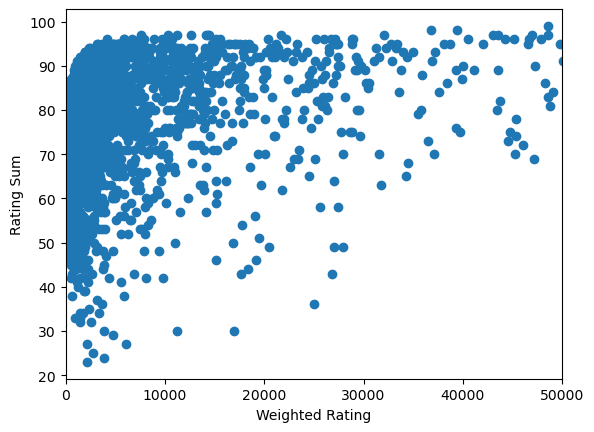

In [6]:
# This visualization is used to show the correlation of weighted rating to rating sum. 
# Games with a higher weighted rating are more likely to have a higher total rating sum.
# Using this correlation, I can justify using the quantile functions above to eliminate games with
# a rating sum below the top 15% of rating sums.
x = game_data.rating_sum
y = game_data.weighted_rating
plt.scatter(x,y)
frame1 = plt.gca()
ax = plt.gca()
ax.set_xlim([0, 50000])
plt.xlabel("Weighted Rating")
plt.ylabel("Rating Sum")
plt.show()

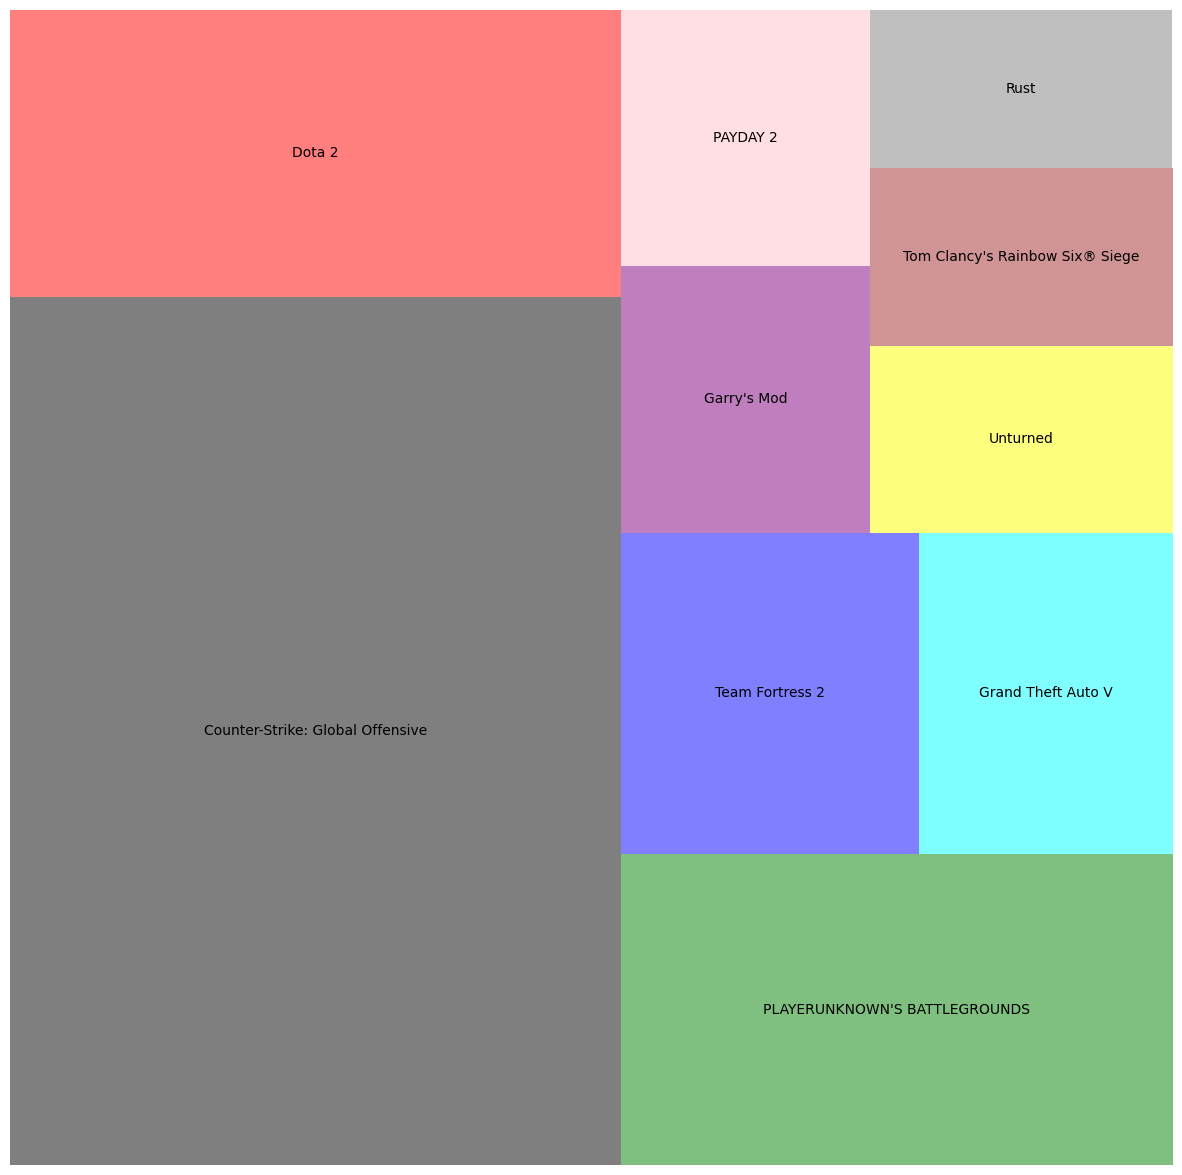

In [7]:
# This visualization is used to show distribution of rating sums across 10 games with the highest rating sum. 
# Here we can see that the 10 most rated games mostly have similar rating sums with Counter-Strike being the exception having
# drastically more rating than any other game. This visualization supports the suggestion of these top 10
# rated games to users when beginning the recommender. By offering suggestions when requesting user input, we can increase
# likelihood of users engaging by suggesting games they are most likely to have heard of or played.
sizes=[50, 25, 12, 6]
label=["50", "25", "12", "6"]
c = ['black', 'red', 'green', 'blue', 'cyan', 'purple', 'pink', 'yellow', 'brown', 'gray']
game_data_sorted = game_data.sort_values('rating_sum', ascending=False)
top_10_rec_games = game_data_sorted.head(10)
fig, ax = plt.subplots(1, figsize = (15,15))
squarify.plot(sizes = top_10_rec_games['rating_sum'], color = c, label= top_10_rec_games['name'], alpha=0.5)
plt.axis('off')
plt.show()

In [8]:
# getters for info when making recommendations
def get_game_year_from_index(index):
    return game_data[game_data.index == index]['year'].values[0]


def get_game_name_from_index(index):
    return game_data[game_data.index == index]['name'].values[0]


def get_game_index_from_name(name):
    return game_data[game_data.name == name].index.values[0]


def get_game_developer_from_index(index):
    return game_data[game_data.index == index]['developer'].values[0]


def get_game_genre_from_index(index):
    return game_data[game_data.index == index]['genres'].values[0]


def get_game_pos_rating_percentage_from_index(index):
    return game_data[game_data.index == index]['pos_rating_percentage'].values[0]


def get_weighted_rating_from_index(index):
    return game_data[game_data.index == index]['weighted_rating'].values[0]


def get_rating_sum_from_index(index):
    return game_data[game_data.index == index]['rating_sum'].values[0]


def get_platforms_from_index(index):
    return game_data[game_data.index == index]['platforms'].values[0]


# levenshtein distance between phrases a and b to determine similarity and find the closest matching phrase
# used for finding phrases closest to user input
def phrase_match_score(a, b):
    return fuzz.ratio(a, b)
    # if a and b are the same the score will be 100


# find closest game name is used for when user inputs a text that doesn't match perfectly with a specific game title
# this way a user can still use the recommender without knowing all games within the dataset
# this is the most typical way for a user to use the recommender
def find_closest_game_name(name):
    # create a list of match differences by index using input
    levenshtein_scores = list(enumerate(game_data['name'].apply(phrase_match_score, b=name)))
    # sort the above list by distance
    sorted_levenshtein_scores = sorted(levenshtein_scores, key=lambda x: x[1], reverse=True)
    # find closest name with the shortest distance
    closest_name = get_game_name_from_index(sorted_levenshtein_scores[0][0])
    # get the score
    distance_score = sorted_levenshtein_scores[0][1]
    return closest_name, distance_score


# TEST for finding closest phrase
# print(find_closest_game_name("Team Fort"))


# this function returns the top 15 closest names to give user options when doing input
def closest_game_names(name):
    levenshtein_scores = list(enumerate(game_data['name'].apply(phrase_match_score, b=name)))
    sorted_levenshtein_scores = sorted(levenshtein_scores, key=lambda x: x[1], reverse=True)
    top_15_closest_names = [get_game_name_from_index(i[0]) for i in sorted_levenshtein_scores[:15]]
    return top_15_closest_names


# TEST for finding closest names of a game
# print(closest_names('Peach'))

def content_based_recommender(user_input_game, number_of_recommendations): #removed platform param at end
    # find closest game name match
    closest_game_name, distance_score = find_closest_game_name(user_input_game)

    # generate a dataframe to store the recommendations in
    recommended_games = pd.DataFrame(
        columns=['Game Title', 'Year', 'Developer', 'Genre', 'Positive Rating Percentage', 'Total Ratings',
                 'Weighted Rating'])

    # find the corresponding index of the game title
    game_index = get_game_index_from_name(closest_game_name)

    # return a list of the most similar game indexes as a list
    games_list = list(enumerate(cosine_similarity_matrix[int(game_index)]))

    # sort list of similar games descending
    similar_games = list(
        filter(lambda x: x[0] != int(game_index), sorted(games_list, key=lambda x: x[1], reverse=True)))

    # print the game that was originally input that the cosine similarity matrix was based on
    print('Here\'s the list of games similar to ' + '\033[1m' + str(closest_game_name) + '\033[0m' + ':\n')

    # Only return the games that are on selected platform
    # n_games = []
    # for i, s in similar_games:
      #  if platform in get_platforms_from_index(i):
            # append method deprecated
       #     print(s)
        #    n_games.append((i, s))
            # n_games = pd.concat([tmp, (i, s)])

    # return the game's (game index, game distance score) and store it
    for i, s in similar_games[int():int(number_of_recommendations)]:
        row = {'Game Title': get_game_name_from_index(i),
               'Year': get_game_year_from_index(i),
               'Developer': get_game_developer_from_index(i),
               'Genre': get_game_genre_from_index(i),
               'Positive Rating Percentage': get_game_pos_rating_percentage_from_index(i),
               'Total Ratings': get_rating_sum_from_index(i),
               'Weighted Rating': get_weighted_rating_from_index(i), }
        tmp = pd.DataFrame.from_dict([row])
        # print(tmp)
        # tmp = []
        # tmp.append(row)
        # append each row to this dataframe
        # append deprecated
        recommended_games = pd.DataFrame(recommended_games, columns = ['Game Title', 'Year', 'Developer',
                                                                       'Genre', 'Positive Rating Percentage',
                                                                      'Total Ratings', 'Weighted Rating'])
        recommended_games = pd.concat([recommended_games, tmp], ignore_index=True)
        # tmp = []
        # recommended_games = pd.concat(tmp, (row)) # add to after row for append , ignore_index=True)
    # if 'Weighted Ratings' in recommended_games.columns:
    #   del game_data['Weighted Ratings']

    return recommended_games# .to_string()

In [13]:
# begin use input
print("What game would you like to find games similar to? Here are some suggestions:")
display(game_data_sorted.head(10))

game_name_text = widgets.Text(
    placeholder='Type a game',
    description='Game Title:',
    disabled=False
)

game_name_btn = widgets.Button(description='Submit')
display(game_name_text, game_name_btn)

def game_name_btn_eventhandler(obj):
    names = closest_game_names(game_name_text.value)
    
    # clarify game in order to ensure recommender works properly may or may not need this
    print("Did you mean one of these games?")
    # display(names)
    game_name_dropdown = widgets.Dropdown(
        options=names,
        placeholder = 'Confirm game choice',
        description='Game Title:',
        disabled=False,
    )
    game_name_dropdown_btn = widgets.Button(description = 'Submit')
    display(game_name_dropdown, game_name_dropdown_btn)
    
    def game_name_dropdown_eventhandler(obj):
        user_input_game = game_name_dropdown.value
        
        print("How many games would you like me to recommend for you? Please type numbers only.")
        num_rec_slider = widgets.IntSlider(
            min=0,
            max=20,
            step=1,
            description='Number of Recommendations:',
            value=10
        )
        num_rec_btn = widgets.Button(description='Submit')
        display(num_rec_slider, num_rec_btn)

        def num_rec_btn_eventhandler(obj):
            number_of_recommendations = num_rec_slider.value
            print("Awesome! I'll start getting you game recommendations.\n")

            recommendations_for_user = content_based_recommender(user_input_game, number_of_recommendations)
# recommendations_for_user.drop('Weighted Ratings', axis=1, inplace=True)
            display(recommendations_for_user)
            print("\nTo start over, run cell again.")
            
    
        num_rec_btn.on_click(num_rec_btn_eventhandler)

    game_name_dropdown_btn.on_click(game_name_dropdown_eventhandler)

game_name_btn.on_click(game_name_btn_eventhandler)    


What game would you like to find games similar to? Here are some suggestions:


,index,appid,name,release_date,english,developer,publisher,platforms,required_age,categories,...,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price,year,pos_rating_percentage,rating_sum,weighted_rating
25,25,730,Counter-Strike: Global Offensive,2012-08-21,1,Valve;Hidden Path Entertainment,Valve,windows;mac;linux,0,Multi-player;Steam Achievements;Full controlle...,...,2644404,402313,22494,6502,50000000-100000000,0.00,2012,0.87,3046717,87.0
22,22,570,Dota 2,2013-07-09,1,Valve,Valve,windows;mac;linux,0,Multi-player;Co-op;Steam Trading Cards;Steam W...,...,863507,142079,23944,801,100000000-200000000,0.00,2013,0.86,1005586,86.0
3378,12836,578080,PLAYERUNKNOWN'S BATTLEGROUNDS,2017-12-21,1,PUBG Corporation,PUBG Corporation,windows,0,Multi-player;Online Multi-Player;Stats,...,496184,487076,22938,12434,50000000-100000000,26.99,2017,0.50,983260,50.0
19,19,440,Team Fortress 2,2007-10-10,1,Valve,Valve,windows;mac;linux,0,Multi-player;Cross-Platform Multiplayer;Steam ...,...,515879,34036,8495,623,20000000-50000000,0.00,2007,0.94,549915,94.0
1383,2478,271590,Grand Theft Auto V,2015-04-13,1,Rockstar North,Rockstar Games,windows,18,Single-player;Multi-player;Steam Achievements;...,...,329061,139308,9837,4834,10000000-20000000,24.99,2015,0.70,468369,70.0
76,121,4000,Garry's Mod,2006-11-29,1,Facepunch Studios,Valve,windows;mac;linux,0,Single-player;Multi-player;Co-op;Cross-Platfor...,...,363721,16433,12422,1875,10000000-20000000,6.99,2006,0.96,380154,96.0
749,1467,218620,PAYDAY 2,2013-08-13,1,OVERKILL - a Starbreeze Studio.,Starbreeze Publishing AB,windows;linux,18,Single-player;Multi-player;Co-op;Online Co-op;...,...,308657,56523,3975,890,10000000-20000000,7.49,2013,0.85,365180,85.0
1688,3362,304930,Unturned,2017-07-07,1,Smartly Dressed Games,Smartly Dressed Games,windows;mac;linux,0,Single-player;Online Multi-Player;Online Co-op...,...,292574,31482,3248,413,20000000-50000000,0.00,2017,0.90,324056,90.0
2184,5235,359550,Tom Clancy's Rainbow Six® Siege,2015-12-01,1,Ubisoft Montreal,Ubisoft,windows,0,Single-player;Multi-player;Co-op;Steam Trading...,...,251178,59620,7504,2543,5000000-10000000,16.99,2015,0.81,310798,81.0
1147,2016,252490,Rust,2018-02-08,1,Facepunch Studios,Facepunch Studios,windows;mac,18,Multi-player;Online Multi-Player;MMO;Co-op;Onl...,...,220370,53709,9352,2234,5000000-10000000,27.79,2018,0.80,274079,80.0


Text(value='', description='Game Title:', placeholder='Type a game')

Button(description='Submit', style=ButtonStyle())

Did you mean one of these games?


Dropdown(description='Game Title:', options=('Counter-Strike', 'Counter-Strike: Source', 'Youtubers Life', 'Co…

Button(description='Submit', style=ButtonStyle())

How many games would you like me to recommend for you? Please type numbers only.


IntSlider(value=10, description='Number of Recommendations:', max=20)

Button(description='Submit', style=ButtonStyle())

Awesome! I'll start getting you game recommendations.

Here's the list of games similar to Counter-Strike:



,Game Title,Year,Developer,Genre,Positive Rating Percentage,Total Ratings,Weighted Rating
0,Team Fortress Classic,1999,Valve,Action FPS Multiplayer,0.84,3951,83.0
1,Deathmatch Classic,2001,Valve,Action FPS Multiplayer,0.83,1540,80.0
2,Ricochet,2000,Valve,Action FPS Multiplayer,0.80,3442,79.0
3,Counter-Strike: Condition Zero,2004,Valve,Action FPS Multiplayer,0.89,13559,88.0
4,Counter-Strike: Source,2004,Valve,Action FPS Multiplayer,0.96,80137,96.0
5,Half-Life 2: Deathmatch,2004,Valve,Action FPS Multiplayer,0.88,6807,87.0
6,Half-Life Deathmatch: Source,2006,Valve,Action FPS Multiplayer,0.74,1835,73.0
7,Bloody Good Time,2010,Outerlight Ltd.,Action Multiplayer FPS,0.76,866,74.0
8,Call of Duty® 4: Modern Warfare®,2007,Infinity Ward;Aspyr (Mac),FPS Action Multiplayer,0.91,9546,90.0
9,Call of Duty®: Modern Warfare® 2,2009,Infinity Ward;Aspyr (Mac),Action FPS Multiplayer,0.91,32832,91.0



To start over, run cell again.
